In [1]:
# TODO: Eventually, I need to include comparisons with the scipy conjguate gradient method

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sopt.optimizers.tensorflow2.utils import BackTrackingLineSearch, AdaptiveLineSearch
from sopt.optimizers.tensorflow2 import NonLinearConjugateGradient


gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def rosenbrock(x):
    x_reshaped = np.reshape(x, [2, -1])
    return np.sum(100*(x_reshaped[1] - x_reshaped[0]**2)**2 + (1 - x_reshaped[0])**2)

In [4]:
x_fn = lambda z: z
z_init = np.zeros(10)

In [5]:
# Tensorflow

v1 = tf.Variable(z_init, dtype='float32')
v2 = tf.Variable(z_init, dtype='float32')
v3 = tf.Variable(z_init, dtype='float32')
v4 = tf.Variable(z_init, dtype='float32')

def tf_rosenbrock(x):
    x_reshaped = tf.reshape(x, [2, -1])
    return tf.reduce_sum(100*(x_reshaped[1] - x_reshaped[0]**2)**2 + (1 - x_reshaped[0])**2)

def obj_and_upd_fn(x, y):
    return tf_rosenbrock(x + y), x + y

def loss_grad_fn(x):
    with tf.GradientTape() as gt:
        loss = tf_rosenbrock(x)
    return loss, gt.gradient(loss, x)

opt1 = NonLinearConjugateGradient(v1, tf_rosenbrock, name='ros', linesearch_type='backtracking')
opt2 = NonLinearConjugateGradient(v2, tf_rosenbrock, name='ros2', linesearch_type='adaptive')

def linesearch_update(ls, v):
    loss, grad = loss_grad_fn(v)
    ls_out = ls.search(obj_and_upd_fn, v, -grad, grad, loss)
    v.assign(ls_out.newx)
    return ls_out.newf

bls = BackTrackingLineSearch()
als = AdaptiveLineSearch()

In [6]:
%%time

cg_als_losses = []
cg_bls_losses = []
als_losses = []
bls_losses = []
for i in tqdm(range(500)):
    cg_bls_losses.append(opt1.minimize().numpy())
    cg_als_losses.append(opt2.minimize().numpy())
    als_losses.append(linesearch_update(bls, v3).numpy())
    bls_losses.append(linesearch_update(als, v4).numpy())


CPU times: user 29.1 s, sys: 1.46 s, total: 30.5 s
Wall time: 23.8 s


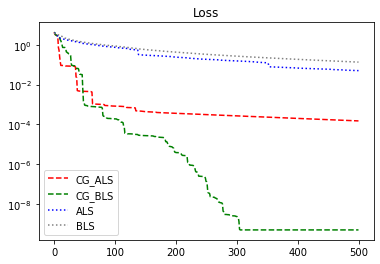

In [7]:
plt.plot(cg_als_losses, color='red', ls='--', label='CG_ALS')
plt.plot(cg_bls_losses, color='green', ls='--', label='CG_BLS')
plt.plot(als_losses, color='blue', ls=':', label='ALS')
plt.plot(bls_losses, color='gray', ls=':', label='BLS')
plt.yscale('log')
plt.title('Loss')
plt.legend(loc='best')
plt.show()